Non-negative Basis Pursuit DeNoising (ADMM)
===========================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.optimize.html#scico.optimize.ADMM) to
solve the non-negative sparse coding problem problem

  $$\mathrm{argmin}_{\mathbf{x}} \; \| \mathbf{y} - D \mathbf{x} \|_2^2
  + \lambda \| \mathbf{x} \|_1 + I(\mathbf{x} \geq 0)\;,$$

where $D$ the dictionary, $\mathbf{y}$ the signal to be represented,
$\mathbf{x}$ is the sparse representation, and $I(\mathbf{x} \geq 0)$
is the non-negative indicator.

In [1]:
import numpy as np

import jax

from scico import functional, linop, loss, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create random dictionary, reference random sparse representation, and
test signal consisting of the synthesis of the reference sparse
representation.

In [2]:
m = 32  # signal size
n = 128  # dictionary size
s = 10  # sparsity level

np.random.seed(1)
D = np.random.randn(m, n)
D = D / np.linalg.norm(D, axis=0, keepdims=True)  # normalize dictionary

xt = np.zeros(n)  # true signal
idx = np.random.randint(low=0, high=n, size=s)  # support of xt
xt[idx] = np.random.rand(s)
y = D @ xt + 5e-2 * np.random.randn(m)  # synthetic signal

xt = jax.device_put(xt)  # convert to jax array, push to GPU
y = jax.device_put(y)  # convert to jax array, push to GPU

Set up the forward operator and ADMM solver object.

In [3]:
lmbda = 1e-1
A = linop.MatrixOperator(D)
f = loss.SquaredL2Loss(y=y, A=A)
g_list = [lmbda * functional.L1Norm(), functional.NonNegativeIndicator()]
C_list = [linop.Identity((n)), linop.Identity((n))]
rho_list = [1.0, 1.0]
maxiter = 100  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=g_list,
    C_list=C_list,
    rho_list=rho_list,
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(),
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [4]:
print(f"Solving on {device_info()}\n")
x = solver.solve()

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  1.49e+00  2.810e+00    1.435e+00  4.750e+00


  10  2.68e+00  4.879e-01    3.589e-02  6.160e-02


  20  3.03e+00  4.753e-01    1.018e-02  2.036e-02


  30  3.48e+00  4.737e-01    2.998e-03  7.681e-03


  40  3.83e+00  4.732e-01    1.711e-03  3.709e-03


  50  4.23e+00  4.731e-01    6.210e-04  8.221e-04


  60  4.52e+00  4.730e-01    1.274e-04  1.549e-04


  70  4.77e+00  4.730e-01    2.507e-05  4.112e-05


  80  4.99e+00  4.730e-01    4.058e-06  0.000e+00


  90  5.18e+00  4.730e-01    1.874e-06  0.000e+00


  99  5.34e+00  4.730e-01    1.829e-06  0.000e+00


Plot the recovered coefficients and signal.

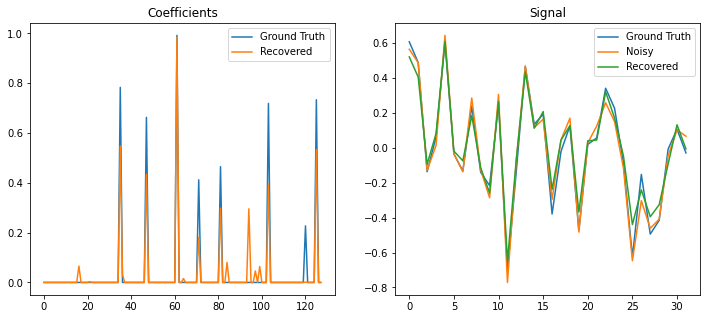

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    np.vstack((xt, solver.x)).T,
    title="Coefficients",
    lgnd=("Ground Truth", "Recovered"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack((D @ xt, y, D @ solver.x)).T,
    title="Signal",
    lgnd=("Ground Truth", "Noisy", "Recovered"),
    fig=fig,
    ax=ax[1],
)
fig.show()